##Overview

This is the 2nd notebook in the YouTube recommendation simulation applied to the MovieLens 1M dataset. It contains:
1. Candidate extraction model
2. Model training and evaluation
3. Candidates extraction to be later used by the Ranking model

The data for this notebook was generated in: "1. RecSys final project - data generation for candidate model.ipynb"

###The candidates model
The purpose of this model is to extract candidates with high recall to predict the next movie viewing for each user (see notebook 1).\
The model uses multiclass classification, where the result should predict the next item out of 3952 movies in the dataset.\
We produce a user elaborate embedding to the same space as item embeddings. The scalar product of the user to each item is then weighted by a softmax to produce class probabilities.
The user representation is done with the following stages:
1. Combining user features which include:\
  a. User viewing history. Items are embedded and averaged together (bag of movies)\
  b. User occupation is embedded from 21 options to a 5d vector space\
  c. User age is embedded from 7 options to a 3d vector space\
  d. User gender and example age are added
2. The features vector is passed through an MLP network with ReLU. We found in experiment that it is better to omit the last ReLU.

Note that the same embeddings are used for the items, both in the user geneartion process and in the final dot product!

###Training
We train the model with cross entropy loss which is applied to the dot product of the user representation with the item embeddings.\
For each positive item, we have 100 negative samples we train against. In order to not to run across all 3951 other items, we use only 100 for each sample (different for each sample), where we use **importance weights** with the proper ratio for compensation. It was found that the importance weights did not make a significant difference in the results.

###Serving
For serving the candidates at realtime, the paper authors took the approach of fast approximate KNN. All final item embedding are represented in a latent space and the candidates are the vectors closest to the user representation in the sense of a dot product.\
We explored several options for approximate KNN such as LSHForest, lshf and faiss. Some tools had compatability issues with the colab platforms and others had performance issues. In the end, since our dataset isn't truely huge like for YouTube, we used the classic KNN implementation from sklearn.\
After each epoch, we build the space of the KNN model with the item embeddings and then use it the extract candidates for all users and evaluate vs the real item.

###Evaluation
The most straight forward evaluation is whether or not our real target item is included in the returned candidates. The results will obviously vary greately depending on the number of returned candidates.\
We chose to evaluate based on returning 100 or 200 candidates.\
Based on the reutrned values we can calculate HR (hit ratio) as well as MRR and NDCG.\
The paper also evaluates MAP, although it does not specify how this is done. For MAP evaluation, we need to get back to a probability space and compare positive and negative results. The way we do this is add negative samples to the validation and test sets as well. We use the same training calculation to obtain dot products, and apply softmax to mimic probabilities. We then take for each sample the positive score and one negative score to compare with labels of 1 and 0. After aggregating all scores we can calculate a ROC curve for all scores and find the area under the graph. Since we only have one class here, AP is enough.

###Hyperparameters
We performed hyperparameter search, evaluated on the validation set. Evaluation was done every 5 epochs for acceleration. We plot below the effect of the MLP size on the results.

###Experiments
We plot the best model training history and evaluate on the test set.\
We present the effect of returning 100 vs. 200 candidates.

###Candidates extraction
The Ranking model needs to receive the candidates for each sample to continue evaluation.\
We built a method for extracting candidates at the end of training for the train, test, and evaluation sets.\
Note that we could have deleted from the candidates list all the items already watched by the user, since unlike YouTube, there are no repetitions of the same movie in the ML dataset. However, this would not be in the spirit of the YouTube implementation where the ranking is looking for maximization of the expected watch time. Keeping watched items as candidates will help teach the ranking model maximize the expected ratings.



**Imports and administration**

In [1]:
# basic
from google.colab import runtime
import os 
import sys
import math
from time import time
import zipfile
import requests
import pickle
import gdown
!pip install --upgrade --no-cache-dir gdown

# general
import warnings
import numpy as np
import pandas as pd
# !pip install scikit-learn
# from sklearn.neighbors import LSHForest
# from sklearn import neighbors.LSHForest
# !apt install libomp-dev
# !python -m pip install --upgrade faiss faiss-gpu
# !pip install faiss-gpu
# import faiss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display, HTML
from tqdm import tqdm
import copy


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the datasets**

In [2]:
url = "https://drive.google.com/file/d/1--fU4VVsoVxUMMQZ7pg4WhKiV1neFfOo/view?usp=share_link"
datasets_path = 'train_10'
gdown.download(url, datasets_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1--fU4VVsoVxUMMQZ7pg4WhKiV1neFfOo
To: /content/train_10
100%|██████████| 402M/402M [00:03<00:00, 117MB/s] 


'train_10'

In [3]:
# You can open from your location/drive location in case gdown doesn't work
# datasets_path = './drive/My Drive/Colab Notebooks/recsys_final_project/train_10'
with open(datasets_path , 'rb') as f:
  (train, test, val, n_items, max_watches, num_neg_samples) = pickle.load(f)
  print('loaded training')

loaded training


In [5]:
n_users = 6040

In [6]:
class Candidates(torch.nn.Module):
    def __init__(self, config):
        super(Candidates, self).__init__()

        self.num_items = config['num_items']
        self.n_neg_samples = config['n_neg_samples']
        self.max_watches = config['max_watches']
        self.latent_dim = config['latent_dim']
        self.features_dim = config['features_dim']
        self.layers = config['layers']

        self.embed_items = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim) #log 4000 ~12
        self.embed_occ = torch.nn.Embedding(num_embeddings=21, embedding_dim=5) # 21 occupations log~5
        self.embed_age = torch.nn.Embedding(num_embeddings=7, embedding_dim=3) # 7 occupations log~3

        self.fc_layers = torch.nn.ModuleList()
        self.fc_layers.append(torch.nn.Linear(self.features_dim, self.layers[0])) #linking features to MLP
        if len(self.layers) > 1:
          for (in_size, out_size) in zip(self.layers[:-1], self.layers[1:]):
              self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        
        # self.LSHIndex = LSHIndex()
        self.N_candidates = config['N_candidates']
        self.knn = KNeighborsClassifier(n_neighbors=self.N_candidates) #initiating the KNN model with maximal N_candidates

    def forward(self, features, mode):
        # previous watches embedding and averaging
        # We must take into account the possible padding with 0's of the user history
        n = self.max_watches
        previous_watches = features[:, :n].int()
        mask = torch.unsqueeze((previous_watches > 0),2)
        embedded_items = self.embed_items(previous_watches)
        sum = mask.sum(dim=1)
        sum[sum == 0] = 1 #so we don't divide by 0 and get nan (even though overwritten)
        embedded_items_mean = (embedded_items*mask).sum(dim=1)/sum
        n_indices = torch.count_nonzero(previous_watches, dim=1)
        embedded_items_mean[(n_indices == 0)] = torch.zeros(self.latent_dim).to(device)

        # other embeddings
        user_age = features[:, n].int()
        emb_age = self.embed_age(user_age)
        user_occupation = features[:, n+1].int()
        emb_occ = self.embed_occ(user_occupation)
        
        # other features
        other_features = features[:, n+2:n+5]
        
        # all
        vector = torch.hstack((embedded_items_mean, emb_age, emb_occ, other_features)).to(torch.float32)

        for idx, _ in enumerate(range(len(self.fc_layers)-1)):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
        vector = self.fc_layers[-1](vector) #last layer without RELU

        if mode == 'training':
          item_id_label = features[:, -self.n_neg_samples-1].int()
          negative_samples = features[:, -self.n_neg_samples:].int() #negative samples are precalculated

          sample_indices = torch.hstack([torch.unsqueeze(item_id_label, 1), negative_samples])
          sample_embeddings = self.embed_items(sample_indices)
          dot_products = torch.matmul(sample_embeddings, torch.unsqueeze(vector, dim = 2))
          return dot_products.squeeze()
    
        elif mode == 'serving':
          # candidates = self.lshf.kneighbors(vector, n_neighbors=self.N_candidates, return_distance=False)
          # candidates = self.LSHIndex.query(vector, k = self.N_candidates)
          candidates = self.knn.kneighbors(vector.detach().cpu().numpy(), return_distance=False)
          return candidates #only indices

In [7]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.model = model.to(self.config['device'])
    self.n_neg_samples = config['n_neg_samples']
    self.labels = torch.hstack((torch.tensor(1), torch.zeros(self.n_neg_samples))).repeat(config['batch_size'], 1).to(device)
    #importance weights with ratio of ~3000/100 = 30
    self.importance_weights = torch.hstack((torch.tensor(1), 30*torch.ones(self.n_neg_samples))).to(device)
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.criterion = config['criterion'](weight = self.importance_weights) #here we add importance weights to the loss function
    self.dl_train = DataLoader(train, batch_size=config['batch_size'], shuffle=True) # create dataloader with given batch size
    self.dl_val = DataLoader(val, batch_size=config['batch_size'], shuffle=False) # create dataloader with given batch size
    self.knn_labels = np.ones(self.model.num_items)
    self.AP_labels = torch.tensor([1, 0]).repeat(1, n_users).squeeze()

  def train(self):
    self.train_loss_history = []
    self.eval_loss_history = []
    self.eval_map_history = []
    self.eval_HR100_history = []
    self.eval_HR200_history = []
    self.eval_MRR100_history = []
    self.eval_MRR200_history = []
    self.eval_NDCG100_history = []
    self.eval_NDCG200_history = []

    epochs_without_improvement = 0
    best_HR = None 
    train_start = time()
    for epoch in range(self.config['n_epochs']):
      self.train_epoch() #train
      self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))
      # extract all embeddings
      all_embeddings = self.model.embed_items(torch.arange(0, n_items).to(device)).detach().cpu().numpy()
      self.model.knn.fit(all_embeddings, self.knn_labels)
      # self.model.LSHIndex.build(all_embeddings)
      # self.model.lshf.kneighbors.fit(all_embeddings)
      if epoch%1 == 0:
      # if epoch%10 == 0:
        self.evaluate_epoch(self.dl_val) #evaluate
        # aggregate metrics: note len(val) = len(test)
        self.eval_loss_history.append(self.epoch_eval_loss/len(self.dl_val))
        average_precision = average_precision_score(self.AP_labels, self.epoch_pred)
        self.eval_map_history.append(average_precision)
        self.eval_HR100_history.append(self.epoch_HR100/len(val))
        self.eval_HR200_history.append(self.epoch_HR200/len(val))
        self.eval_MRR100_history.append(self.epoch_MRR100/len(val))
        self.eval_MRR200_history.append(self.epoch_MRR200/len(val))
        self.eval_NDCG100_history.append(self.epoch_NDCG100/len(val))
        self.eval_NDCG200_history.append(self.epoch_NDCG200/len(val))
        print(f'epoch {epoch}: loss = {self.train_loss_history[-1]}, HR@200 = {self.eval_HR200_history[-1]}, AP = {self.eval_map_history[-1]}')
        # print(f'epoch {epoch}: loss = {self.train_loss_history[-1]}, HR@200 = {self.eval_HR200_history[-1]}')
        #check for early stopping
        if not best_HR or self.eval_HR200_history[-1] > best_HR:
          best_HR = self.eval_HR200_history[-1]
          # best_MRR200 = self.eval_MRR200_history[-1]
          # best_NDCG200 = self.eval_NDCG200_history[-1]
          # best_loss = self.eval_loss_history[-1]
          epochs_without_improvement = 0
          #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
          best_model = copy.deepcopy(self.model.state_dict())
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement == self.config['early_stopping']:
          if self.config['verbose']:
              print('\nEarly stoping after {} epochs. validation loss did not imporve for more than {} epcochs'.format(epoch, self.config['early_stopping']))
          break
    self.training_time = time() - train_start

    # load best model and best performance
    self.model.load_state_dict(best_model)
    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Hit Ratio eval = {best_HR}')
    
  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)

  def train_batch(self, batch):
     
    batch = batch.to(device)  
    pred = self.model(batch, mode = 'training')
    labels = self.labels
    if pred.shape[0] < self.config['batch_size']:
      labels = torch.hstack((torch.tensor(1), torch.zeros(self.n_neg_samples))).repeat(pred.shape[0], 1).to(device)
    loss = self.criterion(pred, labels)
              
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()               
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.epoch_eval_loss = 0
    self.epoch_pred = torch.empty(0) #Aggregated for AP calculation
    self.epoch_HR100 = 0
    self.epoch_HR200 = 0
    self.epoch_MRR100 = 0
    self.epoch_MRR200 = 0
    self.epoch_NDCG100 = 0
    self.epoch_NDCG200 = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch) # dl_val was built so that one batch is one user


  def eval_batch(self, batch):
    target_items = batch[:, -num_neg_samples-1]
    # Send tensor to GPU    
    batch = batch.to(device)

    #evaluations of candidates retrieval
    candidates_batch = self.model(batch, mode = 'serving') #already returned sorted from high to low
    for candidates, target_item in zip(candidates_batch, target_items):
      self.epoch_HR100 += self.HitRatio(candidates, target_item, 100)
      self.epoch_HR200 += self.HitRatio(candidates, target_item, 200)
      self.epoch_MRR100 += self.MRR(candidates, target_item, 100)
      self.epoch_MRR200 += self.MRR(candidates, target_item, 200)
      self.epoch_NDCG100 += self.NDCG(candidates, target_item, 100)
      self.epoch_NDCG200 += self.NDCG(candidates, target_item, 200)
  
    #AP evaluation using negative samples
    pred = self.model(batch, mode = 'training') # not really training - extracts negative samples prediction for AP calculation
    labels = self.labels
    if pred.shape[0] < self.config['batch_size']:
      labels = torch.hstack((torch.tensor(1), torch.zeros(self.n_neg_samples))).repeat(pred.shape[0], 1).to(device)
    loss = self.criterion(pred, labels)        
    self.epoch_eval_loss += loss.item()

    probabilities = F.softmax(pred.detach().cpu(), dim = 1)
    for prob in probabilities: #concatenating predictions for average precision calculation at the end of the epoch
      self.epoch_pred = torch.hstack((self.epoch_pred, prob[:2])) #first two here (positive and negative)


  def extract_candidates(self, dl_eval):
    self.model.eval() #evaluation mode
    all_candidates = np.empty((0, self.model.N_candidates))
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        target_items = batch[:, -num_neg_samples-1]
        # Send tensor to GPU    
        batch = batch.to(device)
        candidates_batch = self.model(batch, mode = 'serving')
        all_candidates = np.vstack([all_candidates, candidates_batch])
        # previous_watches = batch[:, :max_watches].int()
        # for candidates, prev_watches in zip(candidates_batch, previous_watches):
        #   #remove previous watches from candidates, since there are no duplicities in this dataset
        #   candidates = [x for x in candidates if x not in prev_watches]
      return all_candidates

  def HitRatio(self, ranked_items, target_item, k):
    for item in ranked_items[:k]:
      if item == target_item:
        return 1
    return 0

  def MRR(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return 1/(i + 1)
    return 0


  def NDCG(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return np.log(2)/np.log(i + 2)
    return 0


###Hyperparameters search
We show optimization for MLP dimensions, as in the paper, after learning rate was optimized as well.\
evaluation was done coarsly every 10 epochs.\
Only HR@200, AP and training time were recorded.

**NOTE - Hyperparameters search takes long to run. My results can be downloaded below**

In [ ]:
results = pd.DataFrame(columns=['maximal width', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [ ]:
def add_results(training_model, results_df, max_width, batch_size, lr):

  MAP = average_precision_score(training_model.AP_labels, training_model.epoch_pred)
  # MAP = training_model.eval_map_history[-1]
  hr200 = training_model.epoch_HR200/len(val)
  tr_time = training_model.training_time

  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'MAP', MAP
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 200, 'HR', hr200

In [ ]:
batch_size = 50
lr = 0.001
layers_list = [[256], [512, 256], [1024, 512, 256], [2048, 1024, 512, 256]]

for layers in layers_list:
  torch.manual_seed(42)
  np.random.seed(42) 
  max_width = layers[0]
  Candidates_config = {'num_items': n_items, 'n_neg_samples': num_neg_samples, 'max_watches': max_watches, 'latent_dim': 256, 'features_dim': 267, 'layers':layers, 'N_candidates':250}
  model_Candidates = Candidates(Candidates_config)

  training_config = {'n_neg_samples': num_neg_samples, 'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.CrossEntropyLoss, 'n_epochs' : 51, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

  training_candidates = Training(model_Candidates, training_config)
  training_candidates.train()
  training_candidates.evaluate_epoch(training_candidates.dl_val)
  add_results(training_candidates, results, max_width, batch_size, lr)


100%|██████████| 121/121 [00:18<00:00,  6.66it/s]


epoch 0: loss = 3.9165266324352745, HR@200 = 0.1652317880794702, AP = 0.8622159968491578


100%|██████████| 121/121 [00:16<00:00,  7.29it/s]


epoch 10: loss = 1.480612393365001, HR@200 = 0.3117549668874172, AP = 0.8980929976593577


100%|██████████| 121/121 [00:16<00:00,  7.42it/s]


epoch 20: loss = 0.8515356474315489, HR@200 = 0.33112582781456956, AP = 0.8916371746376804


100%|██████████| 121/121 [00:16<00:00,  7.40it/s]


epoch 30: loss = 0.5130948499881274, HR@200 = 0.34089403973509935, AP = 0.8888053648365548


100%|██████████| 121/121 [00:16<00:00,  7.19it/s]


epoch 40: loss = 0.3361056389250108, HR@200 = 0.3531456953642384, AP = 0.8866138382634433


100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 50: loss = 0.2553798374607357, HR@200 = 0.3650662251655629, AP = 0.8845265827478196

Finished Training:
Best metrics are:
Hit Ratio eval = 0.3650662251655629


100%|██████████| 121/121 [00:17<00:00,  6.79it/s]


epoch 0: loss = 3.18288490515671, HR@200 = 0.12367549668874173, AP = 0.8779202237486453


100%|██████████| 121/121 [00:16<00:00,  7.41it/s]


epoch 10: loss = 1.8296195665732125, HR@200 = 0.26076158940397354, AP = 0.9122177605988251


100%|██████████| 121/121 [00:16<00:00,  7.33it/s]


epoch 20: loss = 1.5852444319930297, HR@200 = 0.2913907284768212, AP = 0.9022723560952739


100%|██████████| 121/121 [00:16<00:00,  7.27it/s]


epoch 30: loss = 1.457980330683143, HR@200 = 0.3044701986754967, AP = 0.8994304637227627


100%|██████████| 121/121 [00:17<00:00,  7.09it/s]


epoch 40: loss = 1.3761343219619713, HR@200 = 0.31374172185430466, AP = 0.8954845895338461


100%|██████████| 121/121 [00:16<00:00,  7.37it/s]


epoch 50: loss = 1.3221054550926417, HR@200 = 0.3228476821192053, AP = 0.8915720052877032

Finished Training:
Best metrics are:
Hit Ratio eval = 0.3228476821192053


100%|██████████| 121/121 [00:18<00:00,  6.45it/s]


epoch 0: loss = 2.985635116854251, HR@200 = 0.123841059602649, AP = 0.8902514835418263


100%|██████████| 121/121 [00:16<00:00,  7.54it/s]


epoch 10: loss = 1.3187795654531347, HR@200 = 0.28642384105960267, AP = 0.8942348798483286


100%|██████████| 121/121 [00:15<00:00,  7.93it/s]


epoch 20: loss = 0.9657766210766423, HR@200 = 0.36390728476821194, AP = 0.8753380742034729


100%|██████████| 121/121 [00:15<00:00,  7.97it/s]


epoch 30: loss = 0.822249587126915, HR@200 = 0.39519867549668874, AP = 0.8649270326265472


100%|██████████| 121/121 [00:14<00:00,  8.18it/s]


epoch 40: loss = 0.7669474759626369, HR@200 = 0.41821192052980133, AP = 0.859070956004541


100%|██████████| 121/121 [00:15<00:00,  7.84it/s]


epoch 50: loss = 0.742650286776834, HR@200 = 0.422682119205298, AP = 0.8539748670952242

Finished Training:
Best metrics are:
Hit Ratio eval = 0.422682119205298


100%|██████████| 121/121 [00:19<00:00,  6.35it/s]


epoch 0: loss = 3.044223021789892, HR@200 = 0.12334437086092716, AP = 0.8802203483410058


100%|██████████| 121/121 [00:15<00:00,  7.56it/s]


epoch 10: loss = 1.3852625407919978, HR@200 = 0.2806291390728477, AP = 0.9024189341527165


100%|██████████| 121/121 [00:16<00:00,  7.33it/s]


epoch 20: loss = 1.092248830061085, HR@200 = 0.3486754966887417, AP = 0.887313475056627


100%|██████████| 121/121 [00:15<00:00,  7.83it/s]


epoch 30: loss = 0.9788210739609816, HR@200 = 0.37003311258278143, AP = 0.8806313732244401


100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 40: loss = 0.9319860671085632, HR@200 = 0.38543046357615895, AP = 0.8736497301773147


100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 50: loss = 0.9396309261117747, HR@200 = 0.3922185430463576, AP = 0.8649271714407303

Finished Training:
Best metrics are:
Hit Ratio eval = 0.3922185430463576


100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_candidates_by_layers'
# with open(path, 'wb') as f:
#   pickle.dump((results), f)

In [5]:
#To download my results:

url = "https://drive.google.com/file/d/1pW8NYd3Ci6nQYWDwV8HcMstnS2j3Mkt8/view?usp=sharing"
results_path = 'train_10'
gdown.download(url, results_path, quiet=False,fuzzy=True)

# results_path = './drive/My Drive/Colab Notebooks/recsys_final_candidates_by_layers' #This is where the results were kept
with open(results_path , 'rb') as f:
  (results) = pickle.load(f)
  print('loaded results')

Downloading...
From: https://drive.google.com/uc?id=1pW8NYd3Ci6nQYWDwV8HcMstnS2j3Mkt8
To: /content/train_10
100%|██████████| 1.50k/1.50k [00:00<00:00, 974kB/s]

loaded results


In [16]:
results

,maximal width,Batch Size,Learning Rate,Topk,Metric,Score
0,256,50,0.001,0,MAP,0.884527
1,256,50,0.001,0,TIME,1293.976152
2,256,50,0.001,200,HR,0.365066
3,512,50,0.001,0,MAP,0.891572
4,512,50,0.001,0,TIME,1477.735158
5,512,50,0.001,200,HR,0.322848
6,1024,50,0.001,0,MAP,0.853975
7,1024,50,0.001,0,TIME,1583.885926
8,1024,50,0.001,200,HR,0.422682
9,2048,50,0.001,0,MAP,0.864927


Text(0.5, 1.0, 'HR@200 as a function of MLP size')

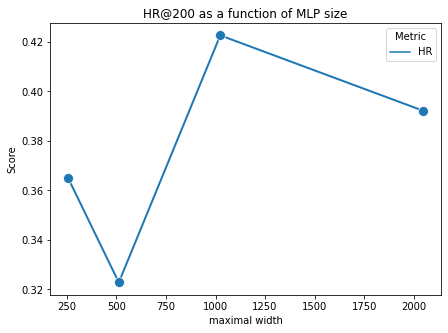

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
HR_results = results[(results['Metric'] == 'HR')]
r = sns.lineplot(data = HR_results, x = 'maximal width', y = 'Score', hue = 'Metric', ax = ax1, marker="o", linewidth = 2, markersize=10)
ax1.set_title('HR@200 as a function of MLP size')

###Running with best parameters

We can see best HR@200 results were obtained with layer of 1024 -> 512 -> 256\
We will use these parameters for extracting the best candidates.

In [8]:
best_results = pd.DataFrame(columns=['maximal width', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [9]:
def add_results(training_model, results_df, max_width, batch_size, lr):

  MAP = average_precision_score(training_model.AP_labels, training_model.epoch_pred)
  loss = training_model.epoch_eval_loss/len(val)
  hr100 = training_model.epoch_HR100/len(val)
  hr200 = training_model.epoch_HR200/len(val)
  mrr100 = training_model.epoch_MRR100/len(val)
  mrr200 = training_model.epoch_MRR200/len(val)
  ndcg100 = training_model.epoch_NDCG100/len(val)
  ndcg200 = training_model.epoch_NDCG200/len(val)
  tr_time = training_model.training_time

  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'LOSS', loss
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'MAP', MAP
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 100, 'HR' , hr100
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 200, 'HR', hr200
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 100, 'MRR', mrr100
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 200, 'MRR', mrr200
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 100, 'NDCG', ndcg100
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 200, 'NDCG', ndcg200

In [10]:
batch_size = 50
dl_test = DataLoader(test, batch_size=batch_size, shuffle=False)
lr = 0.001
layers = [1024, 512, 256] 

torch.manual_seed(42)
np.random.seed(42) 
maximal_width = layers[0]
Candidates_config = {'num_items': n_items, 'n_neg_samples': num_neg_samples, 'max_watches': max_watches, 'latent_dim': 256, 'features_dim': 267, 'layers':layers, 'N_candidates':250}
model_Candidates = Candidates(Candidates_config)

training_config = {'n_neg_samples': num_neg_samples, 'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
              'criterion' : torch.nn.CrossEntropyLoss, 'n_epochs' : 61, 'early_stopping' : 8, 'verbose' : True, 'device' : device}


training_candidates = Training(model_Candidates, training_config)
training_candidates.train()
training_candidates.evaluate_epoch(dl_test)
add_results(training_candidates, best_results, maximal_width, batch_size, lr)

100%|██████████| 121/121 [00:54<00:00,  2.22it/s]


epoch 0: loss = 2.985635116854251, HR@200 = 0.123841059602649, AP = 0.8902514835418263


100%|██████████| 121/121 [00:52<00:00,  2.29it/s]


epoch 1: loss = 2.3531749174492247, HR@200 = 0.15298013245033112, AP = 0.9039160358678995


100%|██████████| 121/121 [00:52<00:00,  2.30it/s]


epoch 2: loss = 2.0934421367795264, HR@200 = 0.16920529801324502, AP = 0.9101487805865497


100%|██████████| 121/121 [00:52<00:00,  2.32it/s]


epoch 3: loss = 1.9223103766015033, HR@200 = 0.18443708609271522, AP = 0.9089599446423223


100%|██████████| 121/121 [00:51<00:00,  2.35it/s]


epoch 4: loss = 1.7935031622352189, HR@200 = 0.20198675496688742, AP = 0.9089031163117349


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 5: loss = 1.6868941866404172, HR@200 = 0.22019867549668873, AP = 0.9091041380111997


100%|██████████| 121/121 [00:50<00:00,  2.37it/s]


epoch 6: loss = 1.5939487972697675, HR@200 = 0.23013245033112584, AP = 0.904697779035101


100%|██████████| 121/121 [00:51<00:00,  2.36it/s]


epoch 7: loss = 1.5111688062055222, HR@200 = 0.2423841059602649, AP = 0.9018264091498228


100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


epoch 8: loss = 1.4399140457147794, HR@200 = 0.2619205298013245, AP = 0.9014885869079028


100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


epoch 9: loss = 1.379266629590104, HR@200 = 0.2768211920529801, AP = 0.8995155687598014


100%|██████████| 121/121 [00:48<00:00,  2.47it/s]


epoch 10: loss = 1.3222219584497394, HR@200 = 0.29172185430463576, AP = 0.8949018598802879


100%|██████████| 121/121 [00:49<00:00,  2.43it/s]


epoch 11: loss = 1.2703111902323385, HR@200 = 0.3029801324503311, AP = 0.891652054503888


100%|██████████| 121/121 [00:50<00:00,  2.40it/s]


epoch 12: loss = 1.2243399960809196, HR@200 = 0.3031456953642384, AP = 0.889523877792137


100%|██████████| 121/121 [00:49<00:00,  2.44it/s]


epoch 13: loss = 1.1808755519226293, HR@200 = 0.31390728476821195, AP = 0.8898344799450553


100%|██████████| 121/121 [00:48<00:00,  2.51it/s]


epoch 14: loss = 1.142773761323943, HR@200 = 0.3258278145695364, AP = 0.8849752321612436


100%|██████████| 121/121 [00:48<00:00,  2.47it/s]


epoch 15: loss = 1.1057765541684548, HR@200 = 0.3294701986754967, AP = 0.8825953103622066


100%|██████████| 121/121 [00:48<00:00,  2.52it/s]


epoch 16: loss = 1.0791296643137143, HR@200 = 0.33410596026490064, AP = 0.8815916308263496


100%|██████████| 121/121 [00:47<00:00,  2.56it/s]


epoch 17: loss = 1.04791480016136, HR@200 = 0.3456953642384106, AP = 0.8785381796245411


100%|██████████| 121/121 [00:48<00:00,  2.51it/s]


epoch 18: loss = 1.0194996748440313, HR@200 = 0.35397350993377485, AP = 0.8762619875353769


100%|██████████| 121/121 [00:46<00:00,  2.59it/s]


epoch 19: loss = 0.9941686137030457, HR@200 = 0.3567880794701987, AP = 0.877838319546459


100%|██████████| 121/121 [00:49<00:00,  2.46it/s]


epoch 20: loss = 0.9725954876534196, HR@200 = 0.3586092715231788, AP = 0.8745530488185673


100%|██████████| 121/121 [00:47<00:00,  2.56it/s]


epoch 21: loss = 0.9579012801858369, HR@200 = 0.3649006622516556, AP = 0.872520385487294


100%|██████████| 121/121 [00:46<00:00,  2.63it/s]


epoch 22: loss = 0.9352796697656051, HR@200 = 0.36837748344370863, AP = 0.8704777996830825


100%|██████████| 121/121 [00:47<00:00,  2.56it/s]


epoch 23: loss = 0.9192064571040158, HR@200 = 0.3736754966887417, AP = 0.8703184027349513


100%|██████████| 121/121 [00:46<00:00,  2.63it/s]


epoch 24: loss = 0.9068663063156881, HR@200 = 0.3710264900662252, AP = 0.8677554286525097


100%|██████████| 121/121 [00:46<00:00,  2.58it/s]


epoch 25: loss = 0.8842872788327814, HR@200 = 0.3801324503311258, AP = 0.8664840483355588


100%|██████████| 121/121 [00:45<00:00,  2.64it/s]


epoch 26: loss = 0.8713143892783598, HR@200 = 0.38973509933774836, AP = 0.8677622675227602


100%|██████████| 121/121 [00:46<00:00,  2.60it/s]


epoch 27: loss = 0.8605160085891453, HR@200 = 0.3892384105960265, AP = 0.8648783079567031


100%|██████████| 121/121 [00:47<00:00,  2.57it/s]


epoch 28: loss = 0.8538794498076502, HR@200 = 0.3870860927152318, AP = 0.8623918658984807


100%|██████████| 121/121 [00:47<00:00,  2.56it/s]


epoch 29: loss = 0.8456055932955828, HR@200 = 0.3928807947019868, AP = 0.8647398956461476


100%|██████████| 121/121 [00:46<00:00,  2.62it/s]


epoch 30: loss = 0.8313578279010507, HR@200 = 0.3925496688741722, AP = 0.8650387151618311


100%|██████████| 121/121 [00:46<00:00,  2.58it/s]


epoch 31: loss = 0.8272992791361268, HR@200 = 0.40049668874172184, AP = 0.8638947244217853


100%|██████████| 121/121 [00:46<00:00,  2.63it/s]


epoch 32: loss = 0.813562180427526, HR@200 = 0.3980132450331126, AP = 0.8602076784864144


100%|██████████| 121/121 [00:46<00:00,  2.59it/s]


epoch 33: loss = 0.8108322581930074, HR@200 = 0.3923841059602649, AP = 0.8598534565539813


100%|██████████| 121/121 [00:45<00:00,  2.64it/s]


epoch 34: loss = 0.802257148931358, HR@200 = 0.4067880794701987, AP = 0.8646590432542733


100%|██████████| 121/121 [00:46<00:00,  2.62it/s]


epoch 35: loss = 0.7953025838939954, HR@200 = 0.4059602649006622, AP = 0.8610773833056327


100%|██████████| 121/121 [00:46<00:00,  2.61it/s]


epoch 36: loss = 0.7938875631484764, HR@200 = 0.4066225165562914, AP = 0.8576166627057996


100%|██████████| 121/121 [00:45<00:00,  2.66it/s]


epoch 37: loss = 0.7918778508926266, HR@200 = 0.40910596026490065, AP = 0.859226549664115


100%|██████████| 121/121 [00:46<00:00,  2.60it/s]


epoch 38: loss = 0.7778904993814841, HR@200 = 0.4059602649006622, AP = 0.8581200560462807


100%|██████████| 121/121 [00:45<00:00,  2.63it/s]


epoch 39: loss = 0.7698487805066914, HR@200 = 0.40794701986754967, AP = 0.8559585502958695


100%|██████████| 121/121 [00:47<00:00,  2.56it/s]


epoch 40: loss = 0.7727484445648872, HR@200 = 0.4120860927152318, AP = 0.8610089522350515


100%|██████████| 121/121 [00:45<00:00,  2.64it/s]


epoch 41: loss = 0.7731416407750537, HR@200 = 0.41258278145695365, AP = 0.8582398030924305


100%|██████████| 121/121 [00:46<00:00,  2.58it/s]


epoch 42: loss = 0.7611127829364198, HR@200 = 0.4187086092715232, AP = 0.8609347530513146


100%|██████████| 121/121 [00:46<00:00,  2.62it/s]


epoch 43: loss = 0.7560382307624284, HR@200 = 0.4140728476821192, AP = 0.8555976827151907


100%|██████████| 121/121 [00:47<00:00,  2.57it/s]


epoch 44: loss = 0.7600039145551524, HR@200 = 0.4163907284768212, AP = 0.8565968200269725


100%|██████████| 121/121 [00:45<00:00,  2.63it/s]


epoch 45: loss = 0.7509632684142384, HR@200 = 0.4230132450331126, AP = 0.8576454828949955


100%|██████████| 121/121 [00:47<00:00,  2.53it/s]


epoch 46: loss = 0.7506480250877655, HR@200 = 0.4206953642384106, AP = 0.8581709761215559


100%|██████████| 121/121 [00:46<00:00,  2.59it/s]


epoch 47: loss = 0.7440497909259323, HR@200 = 0.4206953642384106, AP = 0.8550293868819493


100%|██████████| 121/121 [00:46<00:00,  2.58it/s]


epoch 48: loss = 0.7461953977887698, HR@200 = 0.41903973509933773, AP = 0.8532709285703381


100%|██████████| 121/121 [00:45<00:00,  2.66it/s]


epoch 49: loss = 0.7468730054845084, HR@200 = 0.4271523178807947, AP = 0.8549212245930295


100%|██████████| 121/121 [00:47<00:00,  2.57it/s]


epoch 50: loss = 0.7465140699809849, HR@200 = 0.4304635761589404, AP = 0.855000593584382


100%|██████████| 121/121 [00:45<00:00,  2.65it/s]


epoch 51: loss = 0.7379647049288086, HR@200 = 0.42649006622516555, AP = 0.8514528606142984


100%|██████████| 121/121 [00:46<00:00,  2.58it/s]


epoch 52: loss = 0.7418534922888441, HR@200 = 0.43096026490066225, AP = 0.8558921226305083


100%|██████████| 121/121 [00:45<00:00,  2.66it/s]


epoch 53: loss = 0.7393753068422936, HR@200 = 0.4208609271523179, AP = 0.8532328681815096


100%|██████████| 121/121 [00:46<00:00,  2.63it/s]


epoch 54: loss = 0.7382533026513773, HR@200 = 0.43195364238410594, AP = 0.8532229656083243


100%|██████████| 121/121 [00:45<00:00,  2.66it/s]


epoch 55: loss = 0.743447283507997, HR@200 = 0.43195364238410594, AP = 0.8532200251338793


100%|██████████| 121/121 [00:45<00:00,  2.65it/s]


epoch 56: loss = 0.7331504098494346, HR@200 = 0.43062913907284767, AP = 0.8516765853918715


100%|██████████| 121/121 [00:46<00:00,  2.61it/s]


epoch 57: loss = 0.72883872614421, HR@200 = 0.43029801324503314, AP = 0.8536634479287872


100%|██████████| 121/121 [00:45<00:00,  2.68it/s]


epoch 58: loss = 0.7325146702506783, HR@200 = 0.433112582781457, AP = 0.8521969269842418


100%|██████████| 121/121 [00:47<00:00,  2.57it/s]


epoch 59: loss = 0.7404741056411471, HR@200 = 0.4324503311258278, AP = 0.8511823308761861


100%|██████████| 121/121 [00:45<00:00,  2.68it/s]


epoch 60: loss = 0.7290462839990756, HR@200 = 0.4367549668874172, AP = 0.8536652650844534

Finished Training:
Best metrics are:
Hit Ratio eval = 0.4367549668874172


100%|██████████| 121/121 [00:46<00:00,  2.61it/s]


In [11]:
best_results #On the test set!!

,maximal width,Batch Size,Learning Rate,Topk,Metric,Score
0,1024,50,0.001,0,LOSS,0.317941
1,1024,50,0.001,0,MAP,0.839425
2,1024,50,0.001,0,TIME,4648.095883
3,1024,50,0.001,100,HR,0.286921
4,1024,50,0.001,200,HR,0.416722
5,1024,50,0.001,100,MRR,0.019753
6,1024,50,0.001,200,MRR,0.020695
7,1024,50,0.001,100,NDCG,0.065553
8,1024,50,0.001,200,NDCG,0.083746


In [12]:
# The final test HR200 evaluation!
training_candidates.epoch_HR200/len(test)

0.41672185430463576

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_candidates_best_results'
# with open(path, 'wb') as f:
#   pickle.dump((best_results), f)

In [13]:
def plot_training_summary(training_model, title):
  with plt.rc_context({'lines.linewidth': 1.5, 'lines.marker' : '.', 'lines.markersize' : 8}):

    epochs = np.arange(len(training_model.train_loss_history)) + 1
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))
    ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
    ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LogLoss')
    ax1.legend()
    ax2.plot(epochs, training_model.eval_HR100_history, 'b', label = 'Hit Ratio @100')
    ax2.plot(epochs, training_model.eval_HR200_history, 'g', label = 'Hit Ratio @200')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Hit Ratio')
    ax2.legend()
    ax3.plot(epochs, training_model.eval_MRR100_history, 'b', label = 'MRR@100')
    ax3.plot(epochs, training_model.eval_MRR200_history, 'g', label = 'MRR@200')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MRR')
    ax3.legend()
    ax4.plot(epochs, training_model.eval_NDCG100_history, 'b', label = 'NDCG@100')
    ax4.plot(epochs, training_model.eval_NDCG200_history, 'g', label = 'NDCG@200')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('NDCG')
    ax4.legend()
    fig.suptitle(title, fontsize = 16)

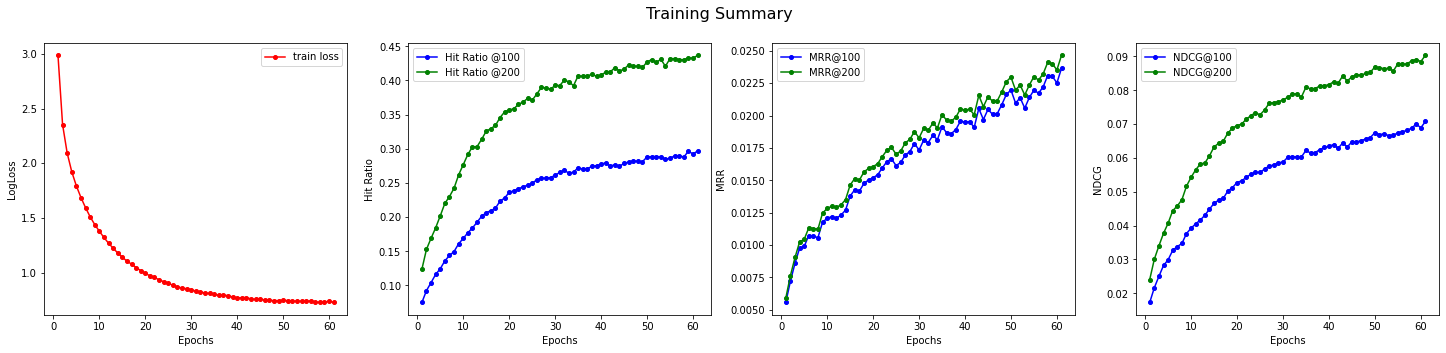

In [ ]:
plot_training_summary(training_candidates, 'Training Summary') #without evaluation loss

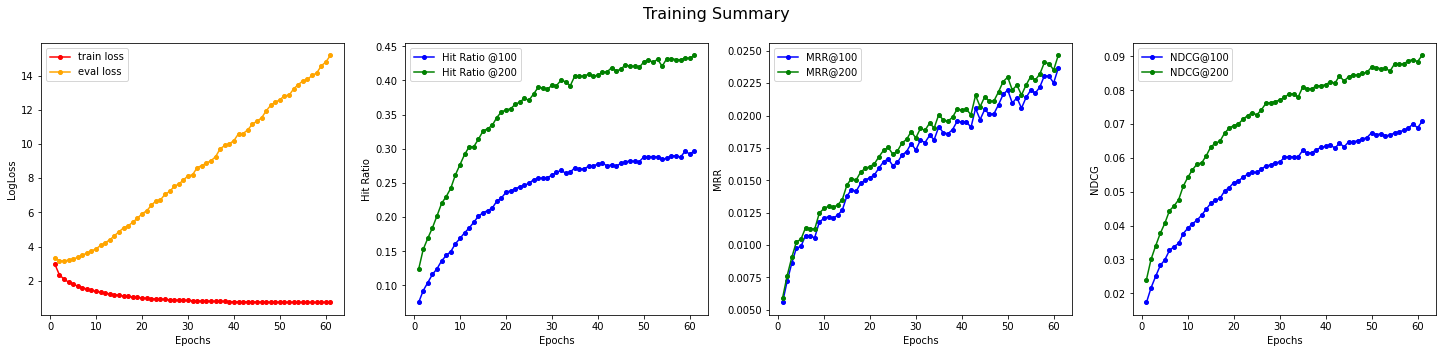

In [14]:
plot_training_summary(training_candidates, 'Training Summary')

###Conclusions from the graphs

1. Our target item will be one of the 100 first candidates retrieved in 28.7% of the cases. It would be 41.7% of the cases, if we returned 200 candidates. This is our starting point before the ranking stage.
2. We can see that the evaluation loss is increasing while the hit-ratio keeps increasing. This suggests that when the target items are being pushed up, other negative samples are given higher scores as well. Since we **only care about high recall** in our case, this can be ok. We expect the ranking network to distinguish between samples again. This behavior should be tested vs the end results. We see that the test HR score is very similar to that of the validation HR. We would definitely not reach such recall if we stopped training when evaluation loss increases.
3. The same trend can be found in the MAP results (graph in the notebook). MAP is shortly increasing, but then starts to decrease. Since MAP is using one threshold for all users, its objective is also not necessarily inline with ranking, and it may not be a good predictor. 
4. As can be expected, while the Hit Ratio is very different for returning 100 vs 200 candidates, the MRR is similar since the additional hits are positioned towards the end of the list.

In [ ]:
def plot_AP_summary(training_model, title):
  with plt.rc_context({'lines.linewidth': 1.5, 'lines.marker' : '.', 'lines.markersize' : 8}):

    epochs = np.arange(len(training_model.train_loss_history)) + 1
    fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
    ax1.plot(epochs, training_model.eval_map_history, 'r', label = 'AP')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AP')
    ax1.legend()

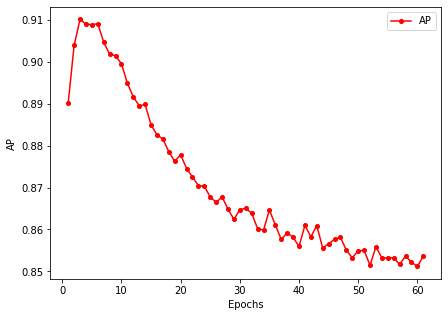

In [ ]:
plot_AP_summary(training_candidates, 'Training Summary')

Average precision shows a similar trend. We are gaining recall in the expense of precision.

###candidates extraction

In [ ]:
#no shuffling, to be able to follow order
# dl_train = DataLoader(train, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(test, batch_size=batch_size, shuffle=False)
dl_val = DataLoader(val, batch_size=batch_size, shuffle=False)

In [ ]:
# We must dilute training
train_indx = []
for user in range(6040):
  offset = 50*user
  # sample = offset + np.random.randint(0, 50)
  sample = offset + 49
  train_indx.append(sample)

In [ ]:
train_sample = train[np.array(train_indx)]
dl_train_sample = DataLoader(train_sample, batch_size=batch_size, shuffle=False)
train_candidates = training_candidates.extract_candidates(dl_train_sample)
all_test_candidates = training_candidates.extract_candidates(dl_test)
all_validation_candidates = training_candidates.extract_candidates(dl_val)
# all_train_candidates = training_candidates.extract_candidates(dl_train) #Too heavy

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/candidates_3'
# with open(path, 'wb') as f:
#   pickle.dump((train_candidates, all_test_candidates, all_validation_candidates), f)

In [ ]:
p_labels = training_candidates.AP_labels
prob = training_candidates.epoch_pred
average_precision = average_precision_score(p_labels, prob)
print(average_precision)

0.8394247444861151


In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precision, recall, thresholds = precision_recall_curve(p_labels, prob)

In [ ]:
precision

array([0.5       , 0.52261263, 0.52320822, ..., 0.98130841, 0.98979592,
       1.        ])

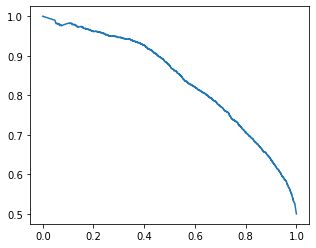

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.plot(recall, precision)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(p_labels, prob)

0.8280850757642209

In [ ]:
from sklearn.metrics import roc_curve

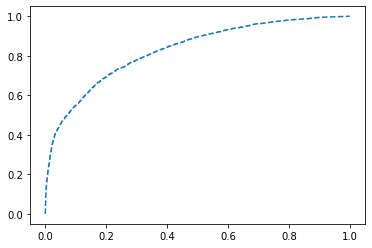

In [ ]:
ns_fpr, ns_tpr, _ = roc_curve(p_labels, prob)
plt.plot(ns_fpr, ns_tpr, linestyle='--')

In [ ]:
path = './drive/My Drive/Colab Notebooks/recsys_final_project/candidates_recall_precision'
with open(path, 'wb') as f:
  pickle.dump((p_labels, prob), f)